# 03 — Machine Learning baseline on Helmholtz data

Goal: train a small CNN/FNO to map inputs → complex fields and report robust metrics.

We’ll:
1) build a synthetic dataset by solving PDEs,
2) train a tiny model (LocalCNN by default),
3) evaluate rel-L2 (mean/median/p90) + magnitude/phase RMSE,
4) visualize predictions vs targets,
5) (optional) save weights and dataset.


In [55]:
from src import PMLConfig

In [1]:
import torch
print(torch.__version__, "CUDA:", torch.cuda.is_available())


2.9.0+cpu CUDA: False


In [17]:
# --- NEW: for a proper test split + metrics ---
from torch.utils.data import random_split
from src.ml import eval_relative_metrics  # keep 'src.' since your package uses relative imports
import torch


In [2]:
# --- BOOTSTRAP (run first) ---
import os, sys, importlib

PROJECT_ROOT = r"C:\Users\31624\Documents\MIT\Programming\FreqTransfer"
os.chdir(PROJECT_ROOT)

# ensure project root is FIRST so our 'src' wins any name collisions
if PROJECT_ROOT in sys.path:
    sys.path.remove(PROJECT_ROOT)
sys.path.insert(0, PROJECT_ROOT)

print("Python:", sys.executable)
print("CWD   :", os.getcwd())
print("sys.path[0]:", sys.path[0])


Python: c:\Users\31624\Documents\MIT\Programming\FreqTransfer\.venv\Scripts\python.exe
CWD   : C:\Users\31624\Documents\MIT\Programming\FreqTransfer
sys.path[0]: C:\Users\31624\Documents\MIT\Programming\FreqTransfer


In [3]:
import src
importlib.reload(src)          # reload package after edits
print("src file:", src.__file__)

import src.ml as ml
importlib.reload(ml)           # reload ml submodule
print("ml file :", ml.__file__)

# quick capability check
for name in ["build_direct_map", "build_freq_transfer", "LocalCNN", "SimpleFNO", "train_model", "eval_relative_metrics"]:
    print(f"{name:22s} ->", hasattr(ml, name))


src file: C:\Users\31624\Documents\MIT\Programming\FreqTransfer\src\__init__.py
ml file : C:\Users\31624\Documents\MIT\Programming\FreqTransfer\src\ml.py
build_direct_map       -> True
build_freq_transfer    -> True
LocalCNN               -> True
SimpleFNO              -> True
train_model            -> True
eval_relative_metrics  -> True


In [4]:
from src import (
    GridSpec,
    build_direct_map, build_freq_transfer,
    LocalCNN, SimpleFNO,
    train_model, eval_relative_metrics,
)
print("OK")


OK


## Experiment knobs

- `task`: choose **"direct"** (RHS→u) or **"transfer"** (u(ω)→u(ω′)).
- Dataset size is kept small for speed; bump when happy.
- Use **LocalCNN** for quick runs; **SimpleFNO** is slower but stronger.


In [ ]:
# --- task selection ---
TASK = "direct"        # "direct" or "transfer"

# --- grid & data ---
grid = GridSpec(2, (48, 48), (1.0, 1.0))
N_SAMPLES = 128        # keep small for quick runs; try 512+ later
K_RANGE = (20.0, 40.0) # for "direct"
OMEGA, OMEGA_P = 25.0, 35.0  # for "transfer"

# --- model ---
MODEL_NAME = "local"   # "local" or "fno"
WIDTH = 48             # channels in the hidden layers

# --- training ---
EPOCHS = 5
BATCH_SIZE = 8
LR = 1e-3
SEED = 0

# --- saving ---
SAVE_DIR = "data/results/03_ml"
os.makedirs(SAVE_DIR, exist_ok=True)


## Build dataset

- **Direct map:** synthesize pairs (RHS[, k]) → solution by assembling and solving.
- **Transfer map:** solve at ω and ω′ with the same RHS, learning u(ω) → u(ω′).


In [6]:
import numpy as np
np.random.seed(SEED)

if TASK == "direct":
    ds = build_direct_map(
        n=N_SAMPLES,
        grid=grid,
        k_range=K_RANGE,
        include_k_channel=True,
        seed=SEED,
        gmres_tol=1e-6,
    )
elif TASK == "transfer":
    ds = build_freq_transfer(
        n=N_SAMPLES,
        grid=grid,
        omega=OMEGA,
        omega_p=OMEGA_P,
        seed=SEED,
        gmres_tol=1e-6,
    )
else:
    raise ValueError("TASK must be 'direct' or 'transfer'")

len(ds), ds[0][0].shape, ds[0][1].shape  # (N, (C_in,H,W), (2,H,W))


(128, torch.Size([3, 48, 48]), torch.Size([2, 48, 48]))

In [32]:
# Inspect typical magnitudes before any normalization
import torch
import numpy as np

x0, y0 = ds_train[0]
print("x channel mins/maxes:", [float(x0[c].min()) for c in range(x0.shape[0])],
      [float(x0[c].max()) for c in range(x0.shape[0])])
print("y abs mean/max:", float(torch.abs(y0).mean()), float(torch.abs(y0).max()))


x channel mins/maxes: [0.0, -0.26860329508781433, 23.99030876159668] [1.1970598697662354, 0.0, 23.99030876159668]
y abs mean/max: 0.00012162762141088024 0.0007571571040898561


In [24]:
# Split the dataset you already built (ds) into train/test
from torch.utils.data import random_split
import torch

test_frac = 0.2
n_total = len(ds)
n_test = max(1, int(round(test_frac * n_total)))
n_train = n_total - n_test

ds_train, ds_test = random_split(ds, [n_train, n_test], generator=torch.Generator().manual_seed(0))

print(f"Train: {len(ds_train)} | Test: {len(ds_test)}")


Train: 102 | Test: 26


In [45]:
# rhs per-channel mean/std over TRAIN (channels 0,1 = Re/Im), leave k as-is
import torch

def compute_rhs_stats(dset):
    # dset is your *original* ds_train (not scaled)
    s0 = torch.zeros(2)
    s1 = torch.zeros(2)
    n = 0
    for i in range(len(dset)):
        x, _ = dset[i]               # x: (C,H,W) tensor
        rhs = x[:2].reshape(2, -1)   # only Re/Im
        s0 += rhs.mean(dim=1)
        s1 += rhs.var(dim=1, unbiased=False)
        n += 1
    m = s0 / n
    v = s1 / n
    std = torch.sqrt(v).clamp_min(1e-6)
    return m.view(2,1,1), std.view(2,1,1)

rhs_mean, rhs_std = compute_rhs_stats(ds_train)
rhs_mean.shape, rhs_std.shape


(torch.Size([2, 1, 1]), torch.Size([2, 1, 1]))

In [46]:
from torch.utils.data import Dataset

K_SCALE = 1.0 / 30.0   # k -> ~O(1)
Y_SCALE = 1e4          # |u| -> ~O(1)

class StdScaledSubset(Dataset):
    def __init__(self, subset, rhs_mean, rhs_std, k_scale=K_SCALE, y_scale=Y_SCALE):
        self.subset = subset
        self.rhs_mean = rhs_mean
        self.rhs_std  = rhs_std
        self.k_scale  = float(k_scale)
        self.y_scale  = float(y_scale)
        x0, _ = subset[0]
        self.has_k = x0.shape[0] == 3

    def __len__(self): return len(self.subset)

    def __getitem__(self, i):
        x, y = self.subset[i]         # tensors
        x = x.clone()
        # standardize Re/Im
        x[:2] = (x[:2] - self.rhs_mean) / self.rhs_std
        # rescale k
        if self.has_k:
            x[2] = x[2] * self.k_scale
        # upscale targets
        y = y * self.y_scale
        return x, y

ds_train_ss = StdScaledSubset(ds_train, rhs_mean, rhs_std, K_SCALE, Y_SCALE)
ds_test_ss  = StdScaledSubset(ds_test,  rhs_mean, rhs_std, K_SCALE, Y_SCALE)


In [47]:
from torch.utils.data import Subset
from src.ml import LocalCNN, train_model

tiny_idx = list(range(min(8, len(ds_train_ss))))
ds_tiny = Subset(ds_train_ss, tiny_idx)

in_ch = ds_tiny[0][0].shape[0]
model_tiny = LocalCNN(in_ch=in_ch, width=96)

# Patch: train with L1 + AdamW + grad clipping (minimal wrapper)
import torch
import numpy as np
from torch.utils.data import DataLoader

def train_once(model, dataset, epochs=150, bs=4, lr=1e-3, clip=1.0, val_frac=0.25):
    n = len(dataset)
    n_val = max(1, int(round(val_frac*n)))
    n_tr  = n - n_val
    tr_set, va_set = torch.utils.data.random_split(dataset, [n_tr, n_val], generator=torch.Generator().manual_seed(0))
    tr = DataLoader(tr_set, batch_size=bs, shuffle=True)
    va = DataLoader(va_set, batch_size=bs, shuffle=False)
    dev = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(dev)
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    loss_fn = torch.nn.L1Loss()
    hist = {"train": [], "val": []}
    for ep in range(1, epochs+1):
        model.train()
        ls=[]
        for x,y in tr:
            x=x.to(dev); y=y.to(dev)
            opt.zero_grad()
            yhat = model(x)
            loss = loss_fn(yhat, y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
            opt.step()
            ls.append(loss.item())
        model.eval()
        vls=[]
        with torch.no_grad():
            for x,y in va:
                x=x.to(dev); y=y.to(dev)
                vls.append(loss_fn(model(x), y).item())
        hist["train"].append(float(np.mean(ls)))
        hist["val"].append(float(np.mean(vls)))
    return model, hist

model_tiny, hist_tiny = train_once(model_tiny, ds_tiny, epochs=200, bs=4, lr=1e-3, clip=1.0)
print("Tiny-overfit last losses:", hist_tiny["train"][-1], hist_tiny["val"][-1])


Tiny-overfit last losses: 0.4931258261203766 14.54635238647461


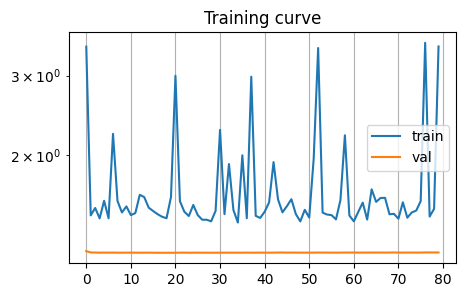

In [48]:
in_ch = ds_train_ss[0][0].shape[0]
model_s = LocalCNN(in_ch=in_ch, width=128)

model_s, hist_s = train_once(
    model_s, ds_train_ss,
    epochs=80, bs=16, lr=7.5e-4, clip=1.0, val_frac=0.2
)

import matplotlib.pyplot as plt
plt.figure(figsize=(5,3))
plt.plot(hist_s['train'], label='train'); plt.plot(hist_s['val'], label='val')
plt.yscale('log'); plt.grid(True); plt.legend(); plt.title('Training curve'); plt.show()


TEST metrics (scaled): {'rel_L2_mean': 0.9974034268122453, 'rel_L2_median': 0.9982361197471619, 'rel_L2_p90': 1.001763641834259, 'mag_RMSE': 4.119858051187987, 'phase_RMSE': 1.8252056646078985}


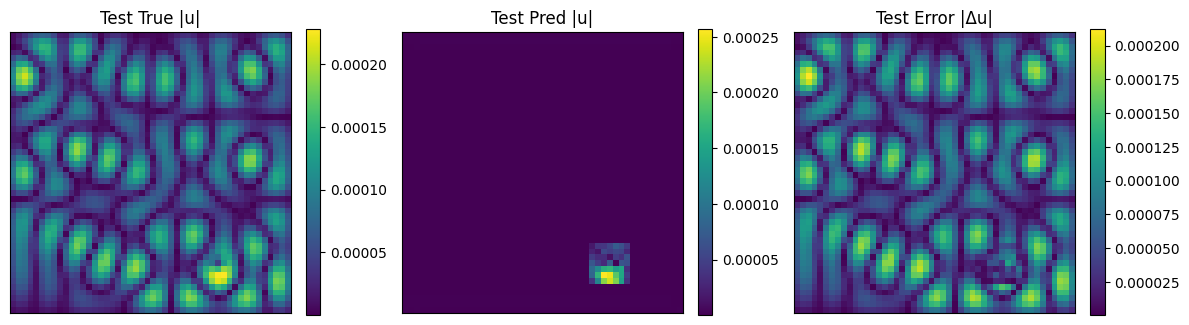

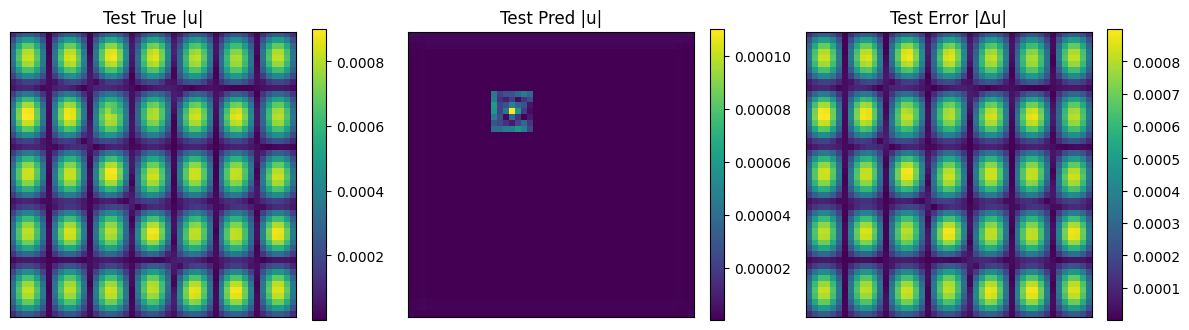

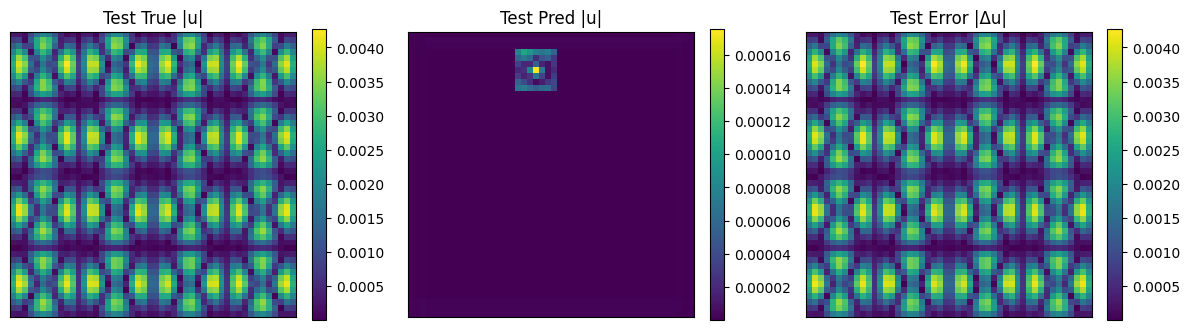

In [49]:
from src.ml import eval_relative_metrics
import torch, numpy as np, matplotlib.pyplot as plt

# metrics in scaled space (rel L2 is still informative)
metrics_test_scaled = eval_relative_metrics(model_s, ds_test_ss, batch_size=16)
print("TEST metrics (scaled):", metrics_test_scaled)

# unscale for plotting
device = "cuda" if torch.cuda.is_available() else "cpu"
model_s = model_s.to(device).eval()

def show_test_example_unscaled(model, ds_split, i=0):
    x, y_s = ds_split[i]
    with torch.no_grad():
        yhat_s = model(x.unsqueeze(0).to(device)).cpu()[0]
    y_true = (y_s / Y_SCALE).numpy()
    y_pred = (yhat_s / Y_SCALE).numpy()

    u_true = y_true[0] + 1j*y_true[1]
    u_pred = y_pred[0] + 1j*y_pred[1]
    err = np.abs(u_pred - u_true)

    fig, axs = plt.subplots(1,3,figsize=(12,4))
    im0 = axs[0].imshow(np.abs(u_true)); axs[0].set_title('Test True |u|'); plt.colorbar(im0, ax=axs[0], fraction=0.046)
    im1 = axs[1].imshow(np.abs(u_pred)); axs[1].set_title('Test Pred |u|'); plt.colorbar(im1, ax=axs[1], fraction=0.046)
    im2 = axs[2].imshow(err);            axs[2].set_title('Test Error |Δu|'); plt.colorbar(im2, ax=axs[2], fraction=0.046)
    for a in axs: a.set_xticks([]); a.set_yticks([])
    plt.tight_layout(); plt.show()

for idx in [0, min(1, len(ds_test_ss)-1), min(5, len(ds_test_ss)-1)]:
    show_test_example_unscaled(model_s, ds_test_ss, i=idx)


In [50]:
for k, v in metrics_test_scaled.items():
    print(f"{k:>15s}: {v:8.3f}")


    rel_L2_mean:    0.997
  rel_L2_median:    0.998
     rel_L2_p90:    1.002
       mag_RMSE:    4.120
     phase_RMSE:    1.825


Test PML

In [63]:
from src import assemble_operator
from src import plot_field

In [61]:
A = assemble_operator(grid, k, pml=None)
u_no_pml = direct_solve(A, b).solution.reshape(grid.shape)


TypeError: unsupported operand type(s) for ** or pow(): 'str' and 'int'

In [62]:
plot_field(u_no_pml, grid.shape)


NameError: name 'plot_field' is not defined

In [ ]:
pml = PMLConfig(thickness=8, m=3, sigma_max=50.0)
A = assemble_operator(grid, k, pml=pml)
u_pml = direct_solve(A, b).solution.reshape(grid.shape)

plot_field(u_pml, grid.shape)


In [51]:
A = assemble_operator(grid, k, pml=None)
u_no_pml = direct_solve(A, b).solution.reshape(grid.shape)


NameError: name 'assemble_operator' is not defined

TEST

In [42]:
# --- zero-baseline (predict y=0) vs your val loss ---
import torch
from torch.utils.data import DataLoader
import numpy as np

def mse_of_zero(dset, n_batches=8, bs=16):
    loader = DataLoader(dset, batch_size=bs, shuffle=False)
    crit = torch.nn.MSELoss()
    mses = []
    for i, (_x, y) in enumerate(loader):
        zero = torch.zeros_like(y)
        mses.append(crit(zero, y).item())
        if i+1 >= n_batches: break
    return float(np.mean(mses))

mse0_train = mse_of_zero(ds_train_s)
mse0_test  = mse_of_zero(ds_test_s)
print(f"Zero-baseline MSE train≈{mse0_train:.3e}  test≈{mse0_test:.3e}")


Zero-baseline MSE train≈2.508e+01  test≈8.527e+00


In [43]:
# --- overfit 8 samples with a simple LocalCNN ---
from torch.utils.data import Subset
from src.ml import LocalCNN, train_model

tiny_idx = list(range(min(8, len(ds_train_s))))
ds_tiny = Subset(ds_train_s, tiny_idx)

in_ch = ds_train_s[0][0].shape[0]
model_tiny = LocalCNN(in_ch=in_ch, width=64)

model_tiny, hist_tiny = train_model(
    model_tiny, ds_tiny,
    epochs=200, batch_size=4, lr=1e-3,
    val_split=0.25, verbose=False,
)

print("Tiny train last:", hist_tiny['train'][-1], "Tiny val last:", hist_tiny['val'][-1])


Tiny train last: 0.7436442673206329 Tiny val last: 593.9642944335938


In [44]:
# --- gradient check on one batch ---
import torch
from torch.utils.data import DataLoader
from src.ml import LocalCNN

dbg = LocalCNN(in_ch=in_ch, width=64)
opt = torch.optim.AdamW(dbg.parameters(), lr=1e-3, weight_decay=1e-4)
crit = torch.nn.MSELoss()

loader = DataLoader(ds_train_s, batch_size=8, shuffle=True)
x, y = next(iter(loader))
opt.zero_grad()
yhat = dbg(x)
loss = crit(yhat, y)
loss.backward()

grad_norm = torch.sqrt(sum((p.grad**2).sum() for p in dbg.parameters() if p.grad is not None)).item()
print(f"One-batch loss: {loss.item():.3e}  grad norm: {grad_norm:.3e}")


One-batch loss: 1.518e+02  grad norm: 1.295e-01


In [36]:
from src.ml import eval_relative_metrics

metrics_test = eval_relative_metrics(model, ds_test, batch_size=16)
print("TEST metrics:", metrics_test)  # rel_L2_mean/median/p90, mag_RMSE, phase_RMSE


TEST metrics: {'rel_L2_mean': 9397.834620549129, 'rel_L2_median': 7738.3515625, 'rel_L2_p90': 17683.861328125, 'mag_RMSE': 1.0018443741998888, 'phase_RMSE': 1.7958763332780185}


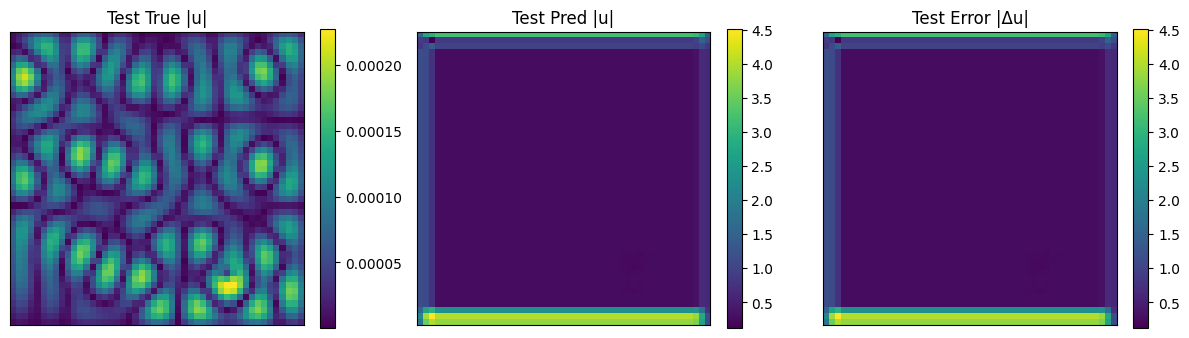

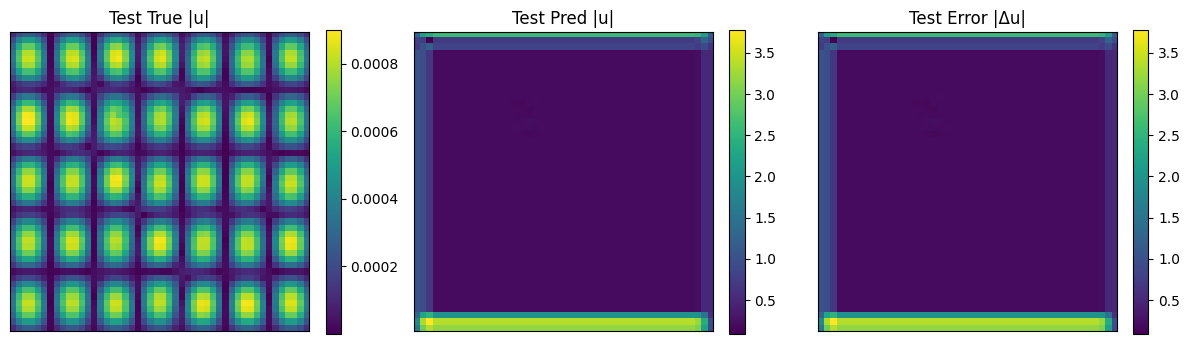

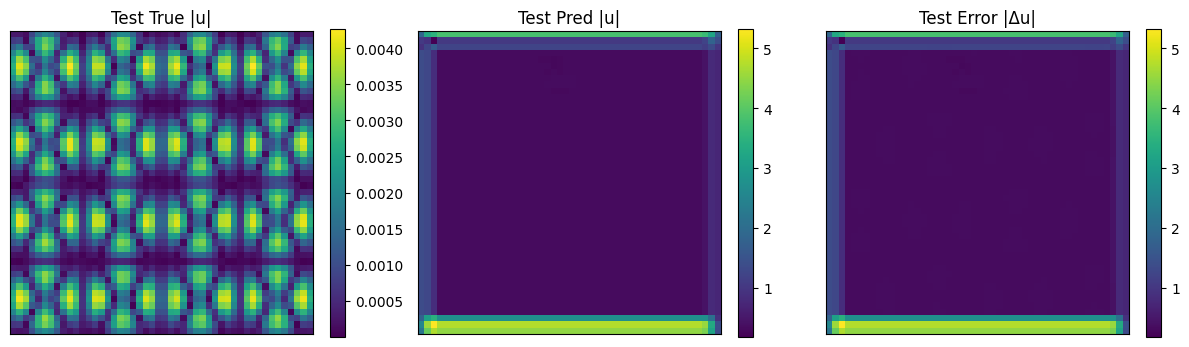

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device).eval()

def show_test_example(model, ds_split, i=0):
    x, y_true = ds_split[i]

    with torch.no_grad():
        y_pred = model(x.unsqueeze(0).to(device)).cpu().numpy()[0]  # (2,H,W) NumPy

    y_true_np = y_true.detach().cpu().numpy()                       # (2,H,W) NumPy

    u_true = y_true_np[0] + 1j * y_true_np[1]
    u_pred = y_pred[0]   + 1j * y_pred[1]
    err = np.abs(u_pred - u_true)

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    im0 = axs[0].imshow(np.abs(u_true)); axs[0].set_title('Test True |u|'); plt.colorbar(im0, ax=axs[0], fraction=0.046)
    im1 = axs[1].imshow(np.abs(u_pred)); axs[1].set_title('Test Pred |u|'); plt.colorbar(im1, ax=axs[1], fraction=0.046)
    im2 = axs[2].imshow(err);            axs[2].set_title('Test Error |Δu|'); plt.colorbar(im2, ax=axs[2], fraction=0.046)
    for a in axs: a.set_xticks([]); a.set_yticks([])
    plt.tight_layout()
    plt.show()

# show a few
idxs = [0, min(1, len(ds_test)-1), min(5, len(ds_test)-1)]
for i in dict.fromkeys(idxs):  # de-dupe while preserving order
    show_test_example(model, ds_test, i=i)


## Save model & config (optional)

Save trained weights and experiment settings for reproducibility.


In [11]:
torch.save(model.state_dict(), os.path.join(SAVE_DIR, f"{MODEL_NAME}_{TASK}_weights.pt"))
with open(os.path.join(SAVE_DIR, "params.txt"), "w") as f:
    f.write(
        f"TASK={TASK}\nGRID={grid.shape}\nN_SAMPLES={N_SAMPLES}\n"
        f"K_RANGE={K_RANGE}\nOMEGA={OMEGA}, OMEGA_P={OMEGA_P}\n"
        f"MODEL={MODEL_NAME}, WIDTH={WIDTH}\nEPOCHS={EPOCHS}, BATCH={BATCH_SIZE}, LR={LR}\n"
    )
print("Saved to:", SAVE_DIR)


Saved to: data/results/03_ml


## FOURIER VERSION


SimpleFNO(
  (proj_in): Conv2d(3, 48, kernel_size=(1, 1), stride=(1, 1))
  (spectral): ModuleList(
    (0-3): 4 x SpectralConv2d()
  )
  (w): ModuleList(
    (0-3): 4 x Conv2d(48, 48, kernel_size=(1, 1), stride=(1, 1))
  )
  (act): GELU(approximate='none')
  (proj_out): Conv2d(48, 2, kernel_size=(1, 1), stride=(1, 1))
)
[001/5] train=8.3240e+03  val=5.1922e+03
[002/5] train=6.9829e+02  val=1.8312e+01
[003/5] train=2.4882e+01  val=1.2225e+01
[004/5] train=3.6079e+00  val=1.4488e+00
[005/5] train=1.0623e+00  val=5.6436e-01
FNO training history: {'train': [8324.004079076982, 698.2945915368887, 24.881517300238976, 3.6079171620882473, 1.062284162411323], 'val': [5192.171630859375, 18.312132358551025, 12.224538803100586, 1.4488483369350433, 0.564358115196228]}
FNO metrics: {'rel_L2_mean': 10775.611458301544, 'rel_L2_median': 8349.3212890625, 'rel_L2_p90': 22354.7236328125, 'mag_RMSE': 1.1115057925585166, 'phase_RMSE': 1.8083811031424988}


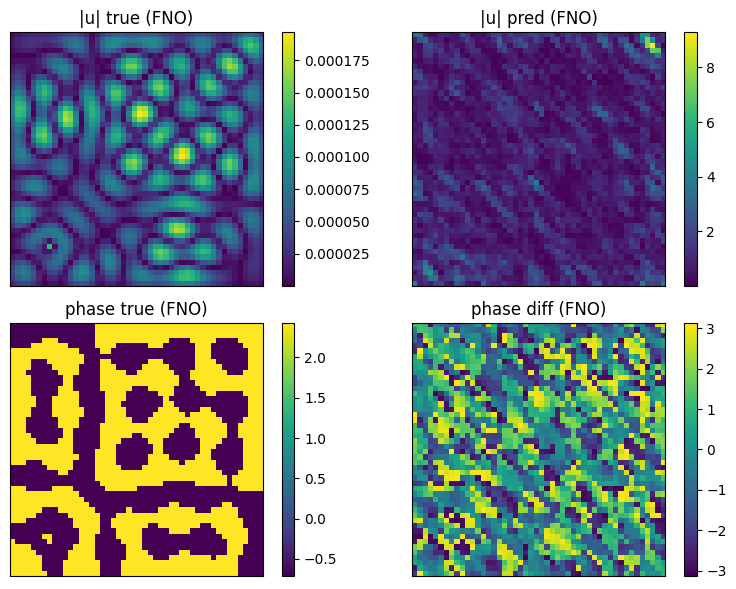

In [12]:
# === FNO experiment (separate from LocalCNN) ===

import torch
import numpy as np
import matplotlib.pyplot as plt

# distinct config names for the FNO run
MODEL_NAME_FNO = "fno"
WIDTH_FNO      = WIDTH       # reuse same width as before
EPOCHS_FNO     = EPOCHS      # reuse same #epochs
BATCH_SIZE_FNO = BATCH_SIZE
LR_FNO         = LR

# build FNO model on the same dataset `ds`, but with new variable names
in_ch_fno = ds[0][0].shape[0]
model_fno = SimpleFNO(
    in_ch=in_ch_fno,
    width=WIDTH_FNO,
    modes=(12, 12),
    layers=4,
)

print(model_fno)

# ---- train FNO ----
model_fno, history_fno = train_model(
    model_fno,
    ds,
    epochs=EPOCHS_FNO,
    batch_size=BATCH_SIZE_FNO,
    lr=LR_FNO,
    val_split=0.2,
    verbose=True,
)
print("FNO training history:", history_fno)

# ---- evaluate FNO ----
metrics_fno = eval_relative_metrics(model_fno, ds, batch_size=16)
print("FNO metrics:", metrics_fno)


# ---- quick visualization helper for FNO (separate from LocalCNN) ----
def show_example_fno(i: int = 0):
    x_fno, y_fno = ds[i]

    with torch.no_grad():
        yhat_fno = model_fno(x_fno.unsqueeze(0)).squeeze(0).cpu().numpy()  # (2,H,W)

    y_true_fno = y_fno.cpu().numpy()

    def to_complex(twoch):
        return twoch[0] + 1j * twoch[1]

    u_pred_fno = to_complex(yhat_fno)
    u_true_fno = to_complex(y_true_fno)

    fig, axes = plt.subplots(2, 2, figsize=(8, 6))

    im0 = axes[0, 0].imshow(np.abs(u_true_fno), origin="lower")
    axes[0, 0].set_title("|u| true (FNO)")
    plt.colorbar(im0, ax=axes[0, 0])

    im1 = axes[0, 1].imshow(np.abs(u_pred_fno), origin="lower")
    axes[0, 1].set_title("|u| pred (FNO)")
    plt.colorbar(im1, ax=axes[0, 1])

    im2 = axes[1, 0].imshow(np.angle(u_true_fno), origin="lower")
    axes[1, 0].set_title("phase true (FNO)")
    plt.colorbar(im2, ax=axes[1, 0])

    # wrap phase diff to [-pi, pi]
    dphi_fno = np.angle(u_pred_fno) - np.angle(u_true_fno)
    dphi_fno = np.angle(np.exp(1j * dphi_fno))

    im3 = axes[1, 1].imshow(dphi_fno, origin="lower")
    axes[1, 1].set_title("phase diff (FNO)")
    plt.colorbar(im3, ax=axes[1, 1])

    for ax in axes.ravel():
        ax.set_xticks([])
        ax.set_yticks([])

    plt.tight_layout()
    plt.show()


# show one example for the FNO model
show_example_fno(i=0)


## Troubleshooting

- **PyTorch missing:** `pip install torch torchvision` (match your Python and CUDA).
- **Slow dataset build:** reduce `N_SAMPLES`, use smaller grids (e.g., 40×40), or increase GMRES tolerance during data synthesis to `1e-5`/`1e-4` temporarily.
- **OOM during training:** lower `WIDTH`, use `BATCH_SIZE=4`, or switch to `LocalCNN`.
- **Metrics look too good/bad:** visualize a few examples (`show_example(i=...)`) to understand failure modes (phase wrapping, boundary effects, etc.).


In [ ]:
import importlib.util, sys
spec = importlib.util.find_spec("src")
print(spec.origin if spec else "src not found")


In [ ]:
# === Second experiment: transfer task with well-separated omegas ===

TASK_far = "transfer"

# choose omegas at least a factor 2 apart
OMEGA_far, OMEGA_P_far = 20.0, 40.0   
N_SAMPLES_far = N_SAMPLES  

# build a separate dataset, to not overwrite ds from the 'direct' run
ds_far = build_freq_transfer(
    n=N_SAMPLES_far,
    grid=grid,
    omega=OMEGA_far,
    omega_p=OMEGA_P_far,
    seed=SEED,
    gmres_tol=1e-6,
)

print(len(ds_far), ds_far[0][0].shape, ds_far[0][1].shape)


128 torch.Size([2, 48, 48]) torch.Size([2, 48, 48])


SimpleFNO(
  (proj_in): Conv2d(2, 48, kernel_size=(1, 1), stride=(1, 1))
  (spectral): ModuleList(
    (0-3): 4 x SpectralConv2d()
  )
  (w): ModuleList(
    (0-3): 4 x Conv2d(48, 48, kernel_size=(1, 1), stride=(1, 1))
  )
  (act): GELU(approximate='none')
  (proj_out): Conv2d(48, 2, kernel_size=(1, 1), stride=(1, 1))
)
[001/10] train=1.0801e+02  val=2.2730e+01
[002/10] train=5.7238e+00  val=1.0003e+00
[003/10] train=4.1905e-01  val=3.3716e-01
[004/10] train=9.7645e-02  val=5.5624e-02
[005/10] train=3.8190e-02  val=2.3584e-02
[006/10] train=1.6316e-02  val=1.1781e-02
[007/10] train=9.2492e-03  val=7.2599e-03
[008/10] train=6.0673e-03  val=4.9882e-03
[009/10] train=4.3715e-03  val=3.7316e-03
[010/10] train=3.3189e-03  val=2.9015e-03
Far-transfer metrics: {'rel_L2_mean': 722.3144688606262, 'rel_L2_median': 643.3631286621094, 'rel_L2_p90': 1181.8869873046874, 'mag_RMSE': 0.07609364078940303, 'phase_RMSE': 1.8105382003494068}


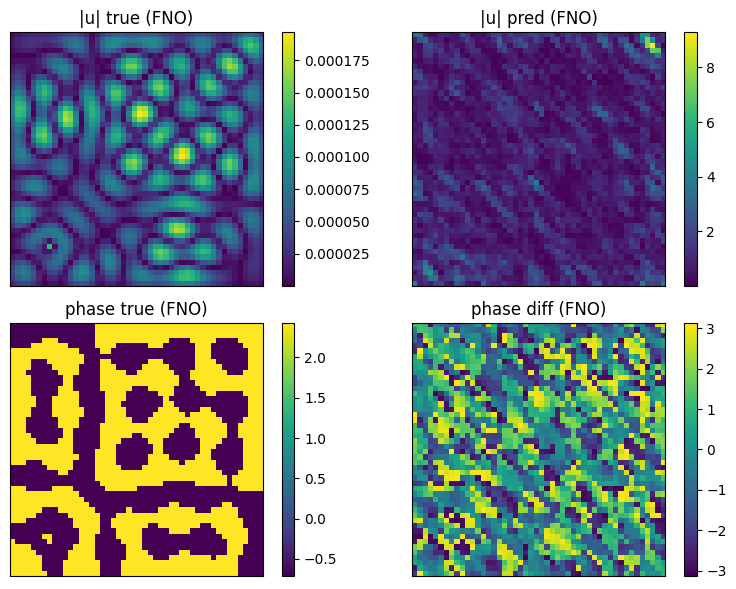

In [16]:
# pick a model type (local or fno) for this experiment
MODEL_NAME_far = "fno"
WIDTH_far      = WIDTH  # or choose a different width if you like

if MODEL_NAME_far == "local":
    model_far = LocalCNN(in_ch=ds_far[0][0].shape[0], width=WIDTH_far)
else:
    model_far = SimpleFNO(in_ch=ds_far[0][0].shape[0], width=WIDTH_far,
                          modes=(12, 12), layers=4)

print(model_far)

model_far, history_far = train_model(
    model_far,
    ds_far,
    epochs=10,
    batch_size=8,
    lr=LR,
    val_split=0.2,
    verbose=True,
)

metrics_far = eval_relative_metrics(model_far, ds_far, batch_size=16)
print("Far-transfer metrics:", metrics_far)

show_example_fno(i=0)